### Static Embeddings
In this notebook, we examine teh CNN LSTM approach using static embeddings for classification https://www.sciencedirect.com/science/article/pii/S2667096820300070


https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

https://keras.io/examples/nlp/bidirectional_lstm_imdb/

https://jaketae.github.io/study/word2vec/

In [ ]:
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install pydot --quiet

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import classification_report

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re
import gensim
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


NOTEBOOK_LOC = "/content/drive/MyDrive/Colab Notebooks/W266 Final Project/"

### Load Data

Also format data for weighted BERT below

In [ ]:
TRAIN_TEXTS = []
VALID_TEXTS = []

TRAIN_LABELS = []
VALID_LABELS = []

TRAIN_WEIGHTS = []

TARGET_NAMES = ["disagree", "neutral", "agree"]

CV_IDX = [4]

for cv_idx in CV_IDX:

  training_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_training_"+str(cv_idx)+".tsv")
  valid_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_val_"+str(cv_idx)+".tsv")


  train_texts = training_data["sentence"].to_list()
  train_labels = np.asarray(training_data["stance_id"].astype(int).to_list())

  valid_texts = valid_data["sentence"].to_list()
  valid_labels = np.asarray(valid_data["stance_id"].astype(int).to_list())

  training_data["weight"] = training_data[["agree", "neutral", "disagree"]].max(axis=1)
  train_weights = np.asarray(training_data["weight"]) # add label weights

  TRAIN_TEXTS.append(train_texts)
  VALID_TEXTS.append(valid_texts)

  TRAIN_LABELS.append(train_labels)
  VALID_LABELS.append(valid_labels)

  TRAIN_WEIGHTS.append(train_weights)

test_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_test.tsv")
test_texts = test_data["sentence"].to_list()
test_labels = np.asarray(test_data["stance_id"].astype(int).to_list())

In [ ]:
train_texts = tf.convert_to_tensor(train_texts, dtype=object)
train_labels = tf.convert_to_tensor(train_labels)

valid_texts = tf.convert_to_tensor(valid_texts, dtype=object)
valid_labels = tf.convert_to_tensor(valid_labels)

test_texts = tf.convert_to_tensor(test_texts, dtype=object)
test_labels = tf.convert_to_tensor(test_labels)

### Embedding Setup

In [ ]:
nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [ ]:
# initialize embedding matrix and word-to-id map:
EMBEDDING_DIM = len(model['university']) 

embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

In [ ]:
embedding_matrix 

array([[ 0.0891758 ,  0.121832  , -0.0671959 , ..., -0.0480419 ,
        -0.0277889 ,  0.0872918 ],
       [ 0.0526281 ,  0.013157  , -0.010104  , ...,  0.0209349 ,
        -0.0537912 ,  0.0654217 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 , ..., -0.00832253,
        -0.00398034, -0.0825016 ],
       ...,
       [ 0.0887422 ,  0.0537124 ,  0.0467064 , ..., -0.0794009 ,
         0.0945805 , -0.0361975 ],
       [-0.011512  ,  0.0173624 , -0.0364862 , ..., -0.0425253 ,
         0.0231499 , -0.014217  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_texts)
valid_tokens = tokenizer.tokenize(valid_texts)
test_tokens = tokenizer.tokenize(test_texts)

valid_tokens[0]

<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'City', b'officials', b'city', b'officials', b'decrying',
       b'global', b'warming', b'out', b'of', b'one', b'side', b'of',
       b'their', b'mouth', b'while', b'downplaying', b'it', b'in',
       b'bond', b'disclosures.'], dtype=object)>

In [ ]:
train_tokens.shape

TensorShape([1476, None])

In [ ]:
MAX_SEQUENCE_LENGTH = 10

def sents_to_ids(token_list_list, label_list, num_examples=100000000):
    """
    converting a list of strings to a list of lists of word ids
    """
    text_ids = []
    text_labels = []
    valid_example_list = []
    example_count = 0
    use_token_list_list = token_list_list[:num_examples]
    for i, token_list in enumerate(use_token_list_list):
        if i < num_examples:
            try:
                example = []
                for token in list(token_list.numpy()):
                    decoded = token.decode('utf-8').replace('.','').replace(',','').replace('!','')
                    try:
                        example.append(vocab_dict[decoded])
                        
                    except:
                        example.append(43981)
                if len(example) >= MAX_SEQUENCE_LENGTH:
                    text_ids.append(example[:MAX_SEQUENCE_LENGTH])
                    text_labels.append(label_list[i])
                    if example_count % 5000 == 0:
                        print('Examples processed: ', example_count)
                    valid_example_list.append(i) 
                    example_count += 1
                else:
                    pass
            except:
                pass

    
    print('Number of examples retained: ', example_count) 
    return (np.array(text_ids),   np.array(text_labels), valid_example_list) 

In [ ]:
train_input, train_input_labels, train_valid_example_list = sents_to_ids(train_tokens, train_labels)
valid_input, valid_input_labels, valid_valid_example_list = sents_to_ids(valid_tokens, valid_labels)
test_input, test_input_labels, test_valid_example_list = sents_to_ids(test_tokens, test_labels)



Examples processed:  0
Number of examples retained:  1261
Examples processed:  0
Number of examples retained:  307
Examples processed:  0
Number of examples retained:  176


#### Simple CNN-LSTM

In [ ]:
def create_cnn_lstm_model(learning_rate=0.00005, 
                          num_filters = [10050, 25],
                          kernel_sizes = [3, 5, 10],
                          dense_layer_dims = [100, 30],
                          dropout_rate = 0.5):
  
  cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
  
  cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

  cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

  h = cnn_embeddings

  conv_layers_for_all_kernel_sizes = []
  for kernel_size, filters in zip(kernel_sizes, num_filters):
      conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
      conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
      conv_layers_for_all_kernel_sizes.append(conv_layer)

  h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
  h = keras.layers.Dropout(rate=dropout_rate)(h)

  for dense_layer_dim in dense_layer_dims:  
    h = keras.layers.Dense(dense_layer_dim, activation='relu')(h)

  # x = tf.keras.layers.Dropout(0.2)(x)
  x = layers.Bidirectional(tf.keras.layers.LSTM(32))(h)
  x = tf.keras.layers.Dense(64, activation="relu")(x)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(x)

  classification_model = tf.keras.Model(inputs=cnn_input_layer, outputs=[classification])
  
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                          metrics='accuracy') 

  return classification_model

In [ ]:
model = create_cnn_lstm_model()
keras.utils.plot_model(model, show_shapes=True, dpi=90)

ValueError: ignored

----------------------Training Cross Fold: 4----------------------
Epoch 1/7
79/79 [==============================] - 16s 18ms/step - loss: 1.0871 - accuracy: 0.4330 - val_loss: 1.0880 - val_accuracy: 0.3583
Epoch 2/7
79/79 [==============================] - 1s 8ms/step - loss: 1.0685 - accuracy: 0.4552 - val_loss: 1.0809 - val_accuracy: 0.3616
Epoch 3/7
79/79 [==============================] - 0s 6ms/step - loss: 1.0500 - accuracy: 0.4544 - val_loss: 1.0787 - val_accuracy: 0.3616
Epoch 4/7
79/79 [==============================] - 0s 6ms/step - loss: 1.0343 - accuracy: 0.4544 - val_loss: 1.0818 - val_accuracy: 0.3616
Epoch 5/7
79/79 [==============================] - 0s 6ms/step - loss: 1.0254 - accuracy: 0.4544 - val_loss: 1.0847 - val_accuracy: 0.3616
Epoch 6/7
79/79 [==============================] - 0s 6ms/step - loss: 1.0222 - accuracy: 0.4544 - val_loss: 1.0869 - val_accuracy: 0.3616
Epoch 7/7
79/79 [==============================] - 0s 6ms/step - loss: 1.0184 - accuracy: 0.4544 

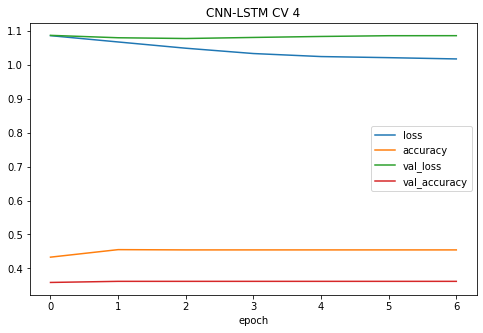

ValueError: ignored

In [ ]:
MODEL_NAME = "CNN-LSTM"
EPOCHS = 7

for cv_idx in CV_IDX[:]:
  model = create_cnn_lstm_model()

  print("----------------------Training Cross Fold: " + str(cv_idx) + "----------------------")

  checkpoint_filepath = 'Models/' + MODEL_NAME + str(cv_idx)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_freq='epoch',
      save_best_only=True)

  model_history = model.fit(train_input,
                            np.array(train_input_labels),
                            validation_data=(valid_input, np.array(valid_input_labels)),    
                                                  batch_size=16,  
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=EPOCHS)
  
  pd.DataFrame(model_history.history).plot(figsize=(8,5))
  plt.title(MODEL_NAME+' CV ' + str(cv_idx))
  plt.xlabel('epoch')
  plt.savefig(NOTEBOOK_LOC + '/ModelResults/' + MODEL_NAME + str(cv_idx) + ".png")
  plt.show()
  
  model.load_weights(checkpoint_filepath)
  test_predictions = model.predict([test_input, np.array(test_input_labels)]) 
  print(classification_report(test_labels, np.argmax(test_predictions, axis=1), target_names=TARGET_NAMES))

  np.save(NOTEBOOK_LOC + '/ModelResults/TestPredictions' + MODEL_NAME + str(cv_idx), test_predictions, allow_pickle=True)